In [321]:
from __future__ import division, print_function
%matplotlib inline

In [322]:
from future.builtins import next

In [323]:
import numpy as np

In [324]:
import qinfer as qi
import qutip as qt

In [325]:
import itertools as it
from functools import partial

In [6]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [676]:
basis = qi.tomography.pauli_basis(2)
model = qi.BinomialModel(qi.tomography.TomographyModel(basis))
prior = qi.tomography.GinibreDistribution(basis)

In [677]:
fiducial_measurement = qt.ket2dm(qt.tensor([qt.basis(2, 0)] * 2))
fiducial_measurement

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]

In [678]:
def PreRotationMeasurements(single_qubit_ops, core_measurement, n_qubits=2, include_conjugate=True):
    """Generate a set of measurement operators based on a set of rotations of a core measurement,
    optionally including the conjugate of the same measurements as well.  Easily generates the sets in
    http://journals.aps.org/pra/pdf/10.1103/PhysRevA.81.062325 using [I, PiX, PiX2, PiY2], M = |00><00|,
    include_conjugate=True"""

    assert (n_qubits == 2) #May optionally generalize later

    FullMeasurementList = []
    
    for m1 in single_qubit_ops:
        for m2 in single_qubit_ops:
            FullMeasurementList.append(np.dot(np.conj(np.kron(m1, m2).T), np.dot(core_measurement, np.kron(m1, m2))))

    if (include_conjugate):
        FullMeasurementList.extend([np.conj(m) for m in FullMeasurementList])

    return FullMeasurementList

#Define Tomographic Measurements
Id = np.eye(2, dtype=complex)
X = np.array([[0.0, 1.0],
              [1.0, 0.0]])
Y = np.array([[0.0, -1.0j],
              [1.0j, 0.0]])
Z = np.array([[1.0, 0.0],
              [0.0, -1.0]])

PiX = np.cos(np.pi/2.) * Id - 1.j * np.sin(np.pi/2.) * X
PiX2 = np.cos(np.pi/4.) * Id - 1.j * np.sin(np.pi/4.) * X
PiY2 = np.cos(np.pi/4.) * Id - 1.j * np.sin(np.pi/4.) * Y

# beta_vec=[0.32182797213542436,0.20388382857043799,0.26690981910827039,0.17047277839951108]
beta_vec=[0.25,.25,.25,.25]
CoreMeasurement = (np.kron(Id, Id) + np.kron(Z, Id) + np.kron(Id,Z) + np.kron(Z,Z))

CoreMeasurement=np.multiply(CoreMeasurement,beta_vec)

SingleMeasurementList = [Id, PiX, PiX2, PiY2]
FullMeasurementList = PreRotationMeasurements(SingleMeasurementList, CoreMeasurement, 
                                              n_qubits=2, include_conjugate=True)

In [680]:
meas_ops=[]
meas_ops += [qt.Qobj(op) for op in FullMeasurementList]

expparams = np.empty((len(meas_ops),),dtype=model.expparams_dtype)

expparams['meas'] = [basis.state_to_modelparams(op) for op in meas_ops]
expparams['n_meas'] = 50

In [681]:
def cycle_heuristic(expparams):
    
    def heuristic(updater):
        return partial(next, it.cycle(expparams[:, np.newaxis]))
    
    return heuristic

In [539]:
perf = qi.perf_test_multiple(50,
    model, 500, prior,
    len(expparams), cycle_heuristic(expparams),
    progressbar=qi.IPythonProgressBar
)

/Users/jcolless/anaconda/lib/python2.7/site-packages/qinfer/smc.py:285: ApproximationWarning: Extremely small n_ess encountered (6.74172039524). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
/Users/jcolless/anaconda/lib/python2.7/site-packages/qinfer/smc.py:285: ApproximationWarning: Extremely small n_ess encountered (9.13020333115). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning


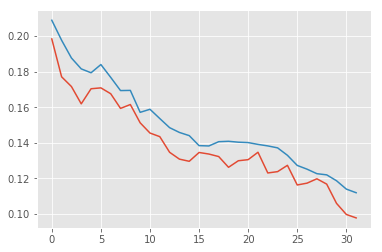

In [540]:
plt.plot(np.median(perf['loss'], axis=0))
plt.plot(np.mean(perf['loss'], axis=0))

## Updater Loop ##

In [688]:
expparams['n_meas'] = 50
number_of_batches = 1

true_state = qt.tensor(qt.Qobj([[1, 0],[0, 0]]),qt.Qobj([[1, 0],[0, 0]]))

true_mps = basis.state_to_modelparams(true_state)[np.newaxis, :]
exp_data=np.round(np.multiply(GS_2[0:32],expparams['n_meas'][0]*number_of_batches))

print(exp_data)
true_state

[ 50.   4.  27.  27.   4.   0.   3.   2.  27.   2.  14.  14.  27.   2.  15.
  15.  50.   4.  27.  27.   4.   1.   3.   2.  27.   3.  15.  14.  27.   2.
  15.  15.]


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]

In [689]:
ideal_data = [0] * 32

for batch in range(number_of_batches):
    i=0
    for experiment in expparams[:, np.newaxis]:
        datum = model.simulate_experiment(true_mps, experiment)
        ideal_data[i]+=datum
        i+=1

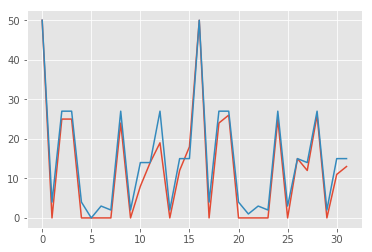

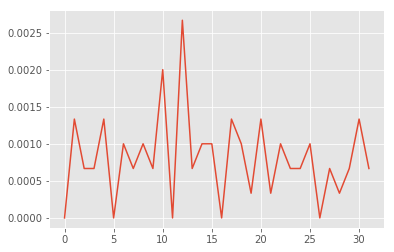

In [690]:
plt.plot(ideal_data)
plt.plot(exp_data)
plt.show()
plt.plot(np.abs(ideal_data-exp_data)/3000)

In [693]:
updater = qi.SMCUpdater(model, 5000, prior)

for batch in range(number_of_batches):
    i=0
    for experiment in expparams[:, np.newaxis]:
        datum=np.round(exp_data[i]/number_of_batches)
        updater.update(datum, experiment)
        i+=1

/Users/jcolless/anaconda/lib/python2.7/site-packages/qinfer/smc.py:285: ApproximationWarning: Extremely small n_ess encountered (2.42199080985). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning


In [694]:
est_state = basis.modelparams_to_state(updater.est_mean())
est_state

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.62861495+0.j         -0.12681858-0.01406297j  0.05443726+0.0934675j
   0.00905773-0.04419037j]
 [-0.12681858+0.01406297j  0.11855300+0.j         -0.04056348-0.04483257j
   0.03851000+0.00011239j]
 [ 0.05443726-0.0934675j  -0.04056348+0.04483257j  0.17069401+0.j
  -0.03616614-0.03596709j]
 [ 0.00905773+0.04419037j  0.03851000-0.00011239j -0.03616614+0.03596709j
   0.08213804+0.j        ]]

In [687]:
true_state

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]

In [455]:
updater.est_mean()

array([ 0.5       ,  0.04847909, -0.07169135,  0.31731047, -0.06881028,
       -0.00680501,  0.13105656, -0.12479183,  0.05672536,  0.03937975,
       -0.00556914,  0.06367069,  0.26528405, -0.03956664, -0.11278846,
        0.24255185])

In [456]:
(true_mps - updater.est_mean())[0, :]

array([ -2.22044605e-16,  -4.84790920e-02,   7.16913482e-02,
         1.82689526e-01,   6.88102787e-02,   6.80501189e-03,
        -1.31056563e-01,   1.24791828e-01,  -5.67253589e-02,
        -3.93797509e-02,   5.56913729e-03,  -6.36706922e-02,
         2.34715954e-01,   3.95666419e-02,   1.12788463e-01,
         2.57448149e-01])

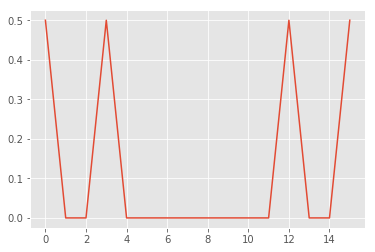

In [457]:
plt.plot(true_mps[0])

<Container object of 16 artists>

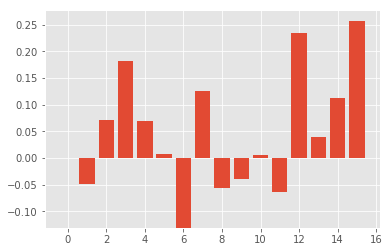

In [458]:
plt.bar(np.arange(16), (true_mps - updater.est_mean())[0, :])
# plt.xticks(np.arange(16) + 0.5, map("${}$".format, basis.labels), rotation='vertical')

NB: we omit the traceful part (modelparam 0) when taking the hull. The convex hull algorithm (quickhull) is fast in the number of points, but very slow in the number of dimensions, so this call will take a long time.

In [ ]:
faces, vertices = updater.region_est_hull(modelparam_slice=np.s_[1:])

In [630]:
import h5py
f = h5py.File('Fiducials.hdf5','r')

for key in f.keys():
    print(key)

GS_2


In [631]:
GS_2=[]

for data in f["GS_2"]:
    GS_2.append(data)

In [632]:
print(np.multiply(GS_2,1000))

[ 993.79707576   75.32122286  533.00841825  532.12228622   80.19494905
    9.74745237   54.05405405   48.73726185  543.19893664   42.53433762
  277.80239256  282.67611874  536.55294639   49.62339389  301.28489145
  295.52503323  990.25254763   82.41027913  543.64200266  541.86973859
   77.53655295   10.19051839   55.3832521    45.19273372  548.95879486
   54.05405405  301.72795747  276.03012849  545.41426673   43.42046965
  295.08196721  294.19583518]


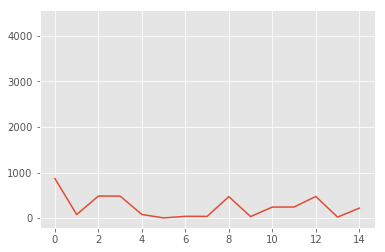

In [633]:
plt.plot(np.multiply(GS[0:15],1000))
# plt.show()
plt.plot(test_data)